# **Import Required Libraries**

In [47]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# **Set Random Seeds for Reproducibility**

In [48]:
# SET RANDOM SEEDS FOR REPRODUCIBILITY

torch.manual_seed(42)

# **Check for GPU**

In [49]:
# CHECK FOR GPU

device = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'cpu'
)


print(f"USING DEVICE: {device}")

USING DEVICE: cuda


# **Load Fashion MNIST Dataset**

In [50]:
df = pd.read_csv('/content/fashion-mnist_train.csv')


df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Check Dataset Shape**

In [51]:
df.shape

(60000, 785)

# **Visualize First 16 Images**

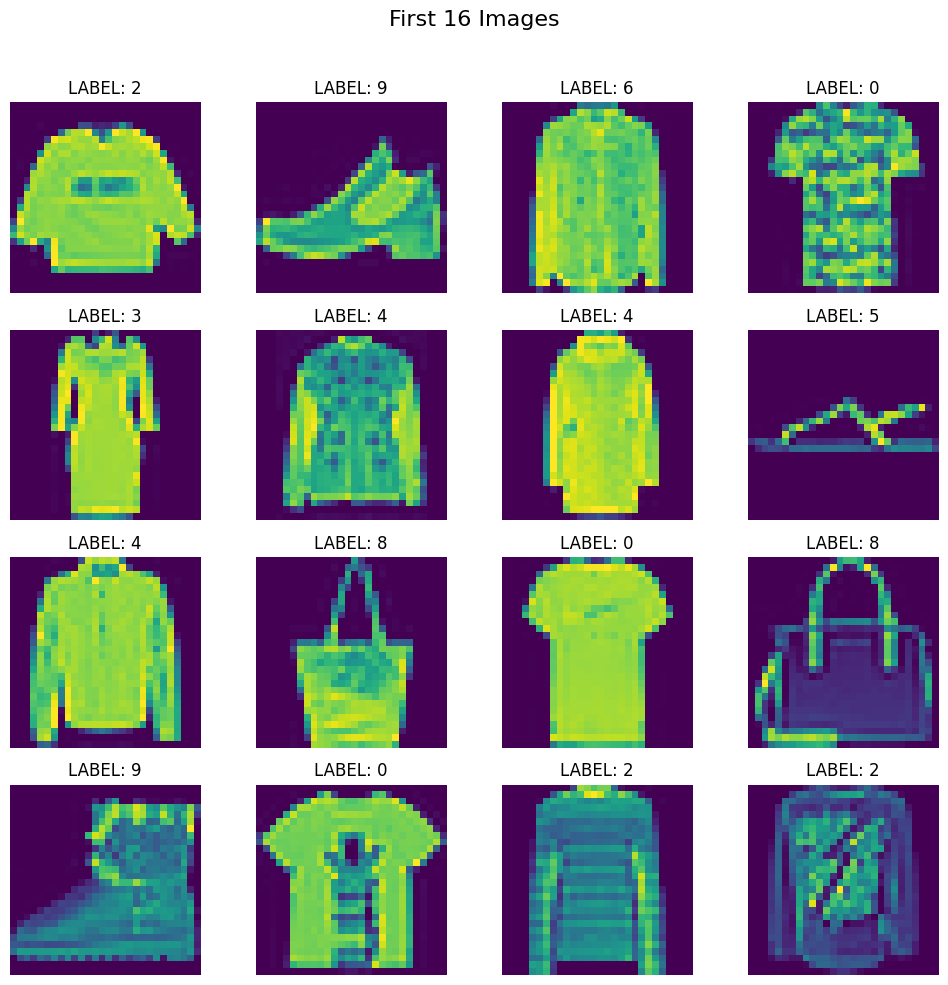

In [52]:
# CREATE A 4X4 GRID OF IMAGES
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)


# PLOT THE FIRST 16 IMAGES FROM THE DATASET
for i, ax in enumerate(axes.flat):
    # RESHAPE TO 28X28
    img = df.iloc[i, 1:].values.reshape(28, 28)

    # DISPLAY IN GRAYSCALE
    ax.imshow(img)

    # REMOVE AXIS FOR A CLEANER LOOK
    ax.axis('off')

    # SHOW THE LABEL
    ax.set_title(f"LABEL: {df.iloc[i, 0]}")


# ADJUST LAYOUT TO FIT THE TITLE
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# **Train-Test Split**

In [53]:
# TRAIN TEST SPLIT

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

# **Split Data into Training and Test Sets**

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# **Normalize Data**

In [55]:
X_train = X_train / 255.0

X_test = X_test / 255.0

# **Custom PyTorch Dataset Class**

In [56]:
class CustomDataset(Dataset):

    def __init__(self, features, labels):

        # CONVERT TO PYTORCH TENSORS
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)


    def __len__(self):
        return len(self.features)


    def __getitem__(self, index):
        return self.features[index], self.labels[index]

# **Create Training Dataset**

In [57]:
train_dataset = CustomDataset(
    X_train,
    y_train
)

# **Create Test Dataset**

In [58]:
test_dataset = CustomDataset(
    X_test,
    y_test
)

# **Define Neural Network Architecture**

In [59]:
class MyNN(nn.Module):

    def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):
        super().__init__()

        layers = []
        for i in range(num_hidden_layers):
            layers.append(nn.Linear(input_dim, neurons_per_layer))
            layers.append(nn.BatchNorm1d(neurons_per_layer))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = neurons_per_layer

        layers.append(nn.Linear(neurons_per_layer, output_dim))

        self.model = nn.Sequential(*layers)


    def forward(self, x):
        return self.model(x)

# **Hyper-Parameter Values**

- Number of Hidden Layers: [1, 5]
- Number of Neurons Per Layers: [8, 128, STEP = 8]

- Epochs: [10, 50, STEP = 10]
- Learning Rate: [1e-5, 1e-1]
- Dropout Rate: [0.1, 0.5, STEP = 0.1]
- Batch Size: {16, 32, 64, 128}
- Optimizer Name: {'Adam', 'SGD', 'RMSprop'}
- Weight Decay: [1e-5, 1e-3]

# **Optuna Objective Function**

In [60]:
# OBJECTIVE FUNCTION
# ------------------
def objective(trial):

    # 1. NEXT HYPERPARAMETER VALUES FROM THE SEARCH SPACE
    # ---------------------------------------------------
    num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
    neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
    epochs = trial.suggest_int("epochs", 10, 50, step=10)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)


    # CREATE DATA LOADERS
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True
    )



    # 2. MODEL INIT
    # -------------
    input_dim = 784
    output_dim = 10

    model = MyNN(
        input_dim,
        output_dim,
        num_hidden_layers,
        neurons_per_layer,
        dropout_rate
    )

    model.to(device)



    # 3. OPTIMIZER SELECTION
    # ----------------------
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )

    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )

    else:
        optimizer = optim.RMSprop(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )



    # 4. TRAINING LOOP
    # ----------------
    for epoch in range(epochs):
        for batch_features, batch_labels in train_loader:

            # MOVE DATA TO GPU
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            # FORWARD PASS
            outputs = model(batch_features)

            # CALCULATE LOSS
            loss = criterion(outputs, batch_labels)

            # BACK PASS
            optimizer.zero_grad()
            loss.backward()

            # UPDATE GRADS
            optimizer.step()



    # 5. EVALUATION ON TEST DATA
    # --------------------------
    model.eval()

    total = 0
    correct = 0

    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            # MOVE DATA TO GPU
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_features)
            _, predicted = torch.max(outputs, 1)

            total = total + batch_labels.shape[0]
            correct = correct + (predicted == batch_labels).sum().item()

        accuracy = correct / total


    return accuracy

# **Install Optuna**

In [61]:
# !pip install optuna

# **Import Optuna**

In [62]:
import optuna

# **Create Optuna Study**

In [63]:
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(),
    study_name='Hyper-Parameter Tuning'
)

[I 2025-09-15 05:42:41,823] A new study created in memory with name: Hyper-Parameter Tuning


# **Run Optuna Optimization**

In [64]:
study.optimize(
    objective,
    n_trials=10
)

[I 2025-09-15 05:43:31,427] Trial 0 finished with value: 0.8325833333333333 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 24, 'epochs': 50, 'learning_rate': 0.059126887277842884, 'dropout_rate': 0.5, 'batch_size': 128, 'optimizer': 'SGD', 'weight_decay': 0.00030170612240266765}. Best is trial 0 with value: 0.8325833333333333.
[I 2025-09-15 05:43:49,692] Trial 1 finished with value: 0.86175 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 96, 'epochs': 20, 'learning_rate': 2.8636998554059424e-05, 'dropout_rate': 0.30000000000000004, 'batch_size': 128, 'optimizer': 'RMSprop', 'weight_decay': 3.0607529451141715e-05}. Best is trial 1 with value: 0.86175.
[I 2025-09-15 05:46:17,896] Trial 2 finished with value: 0.8856666666666667 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 120, 'epochs': 30, 'learning_rate': 0.00023996259726627293, 'dropout_rate': 0.5, 'batch_size': 16, 'optimizer': 'RMSprop', 'weight_decay': 5.5742678152036773e-05}. Best is tr

# **Show Best Accuracy**

In [65]:
study.best_value

0.8856666666666667

# **Show Best Hyperparameters**

In [66]:
study.best_params

{'num_hidden_layers': 1,
 'neurons_per_layer': 120,
 'epochs': 30,
 'learning_rate': 0.00023996259726627293,
 'dropout_rate': 0.5,
 'batch_size': 16,
 'optimizer': 'RMSprop',
 'weight_decay': 5.5742678152036773e-05}